<div class="jumbotron">
  <h1 class="display-3">Third (basic) lesson with Abinit and AbiPy</h1>
  <p class="lead">Crystalline silicon.</p> 
  <hr class="my-4">
  <p>This lesson aims at showing you how to get the following physical properties, for an insulator:

the total energy
the lattice parameter
the band structure (actually, the Kohn-Sham band structure) You will learn about the use of k-points, as well as the smearing of the plane-wave kinetic energy cut-off.
This lesson should take about 1 hour.
</p>
  <p class="lead">
    <a class="btn btn-primary btn-lg" href="#" role="button">Learn more</a>
  </p>
</div>

In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import print_function, division, unicode_literals

import numpy as np
import seaborn

from abipy import abilab

# This line tells the notebook to show plots inside of the notebook
%matplotlib notebook

## Computing the total energy of silicon at fixed number of k-points

In [2]:
from lesson_base3 import build_ngkpt_flow
abilab.print_source(build_ngkpt_flow)

In [3]:
with abilab.GsrRobot.from_dir("flow_base3_ngkpt") as robot:
    table = robot.get_dataframe()  

monkhorst_pack_folding variables has not been written to netcdf file.
Received [-2147483647 -2147483647 -2147483647]
Set mpdivs to None, this could create problems in post-processing tools.
If needed, use python netcdf to change the value of `monkhorst_pack_folding`
monkhorst_pack_folding variables has not been written to netcdf file.
Received [-2147483647 -2147483647 -2147483647]
Set mpdivs to None, this could create problems in post-processing tools.
If needed, use python netcdf to change the value of `monkhorst_pack_folding`
monkhorst_pack_folding variables has not been written to netcdf file.
Received [-2147483647 -2147483647 -2147483647]
Set mpdivs to None, this could create problems in post-processing tools.
If needed, use python netcdf to change the value of `monkhorst_pack_folding`
monkhorst_pack_folding variables has not been written to netcdf file.
Received [-2147483647 -2147483647 -2147483647]
Set mpdivs to None, this could create problems in post-processing tools.
If needed

In [4]:
table.keys()

Index(['energy', 'pressure', 'max_force', 'ecut', 'pawecutdg', 'tsmear',
       'nkpt', 'nsppol', 'nspinor', 'nspden', 'formula', 'natom', 'angle0',
       'angle1', 'angle2', 'a', 'b', 'c', 'volume', 'abispg_num',
       'spglib_symb', 'spglib_num'],
      dtype='object')

In [5]:
table["energy_Ha"] = table["energy"] * abilab.units.eV_to_Ha
table[["nkpt", "energy", "energy_Ha"]]

,nkpt,energy,energy_Ha
flow_base3_ngkpt/w0/t0/outdata/out_GSR.nc,2,-241.251546,-8.865831
flow_base3_ngkpt/w0/t1/outdata/out_GSR.nc,10,-241.417959,-8.871946
flow_base3_ngkpt/w0/t2/outdata/out_GSR.nc,28,-241.421158,-8.872064
flow_base3_ngkpt/w0/t3/outdata/out_GSR.nc,60,-241.421391,-8.872073


<IPython.core.display.Javascript object>


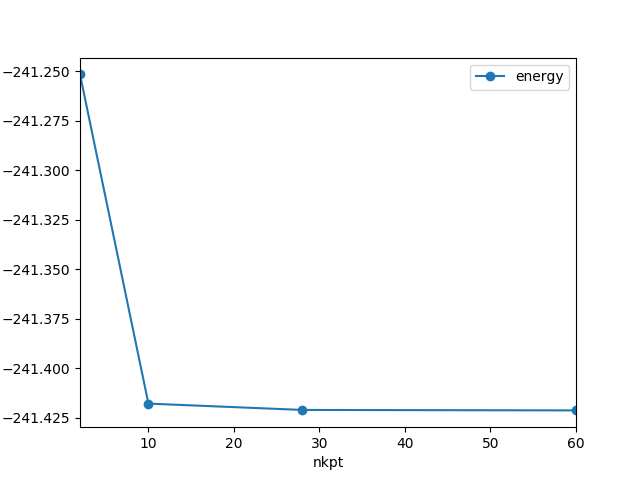

In [6]:
table.plot(x="nkpt", y="energy", style="-o");

## Determination of the lattice parameters

In [7]:
from lesson_base3 import build_relax_flow
abilab.print_source(build_relax_flow)

In [8]:
with abilab.GsrRobot.from_dir("flow_base3_relax") as robot:
    table = robot.get_dataframe()
    dfs = robot.get_structure_dataframes()

monkhorst_pack_folding variables has not been written to netcdf file.
Received [-2147483647 -2147483647 -2147483647]
Set mpdivs to None, this could create problems in post-processing tools.
If needed, use python netcdf to change the value of `monkhorst_pack_folding`
monkhorst_pack_folding variables has not been written to netcdf file.
Received [-2147483647 -2147483647 -2147483647]
Set mpdivs to None, this could create problems in post-processing tools.
If needed, use python netcdf to change the value of `monkhorst_pack_folding`


In [9]:
table

,energy,pressure,max_force,ecut,pawecutdg,tsmear,nkpt,nsppol,nspinor,nspden,...,angle0,angle1,angle2,a,b,c,volume,abispg_num,spglib_symb,spglib_num
flow_base3_relax/w0/t0/outdata/out_GSR.nc,-241.255628,-0.013234,5.358884e-27,8.0,-1.0,0.01,2,1,1,1,...,60.0,60.0,60.0,3.829282,3.829282,3.829282,39.704243,227,Fd-3m,227
flow_base3_relax/w0/t1/outdata/out_GSR.nc,-241.425215,-0.008754,3.504667e-27,8.0,-1.0,0.01,10,1,1,1,...,60.0,60.0,60.0,3.822962,3.822962,3.822962,39.507977,227,Fd-3m,227


In [10]:
dfs.lattice

,formula,natom,angle0,angle1,angle2,a,b,c,volume,abispg_num,spglib_symb,spglib_num
flow_base3_relax/w0/t0/outdata/out_GSR.nc,Si2,2,60.0,60.0,60.0,3.829282,3.829282,3.829282,39.704243,227,Fd-3m,227
flow_base3_relax/w0/t1/outdata/out_GSR.nc,Si2,2,60.0,60.0,60.0,3.822962,3.822962,3.822962,39.507977,227,Fd-3m,227


## Computing the band structure

In [11]:
with abilab.abiopen("flow_base3_ebands/w0/t1/outdata/out_GSR.nc") as gsr:
    ebands_kpath = gsr.ebands

/Users/gmatteo/git_repos/pymatgen/pymatgen/symmetry/bandstructure.py:63: UserWarning: The input structure does not match the expected standard primitive! The path can be incorrect. Use at your own risk.
  warnings.warn("The input structure does not match the expected standard primitive! "


<IPython.core.display.Javascript object>


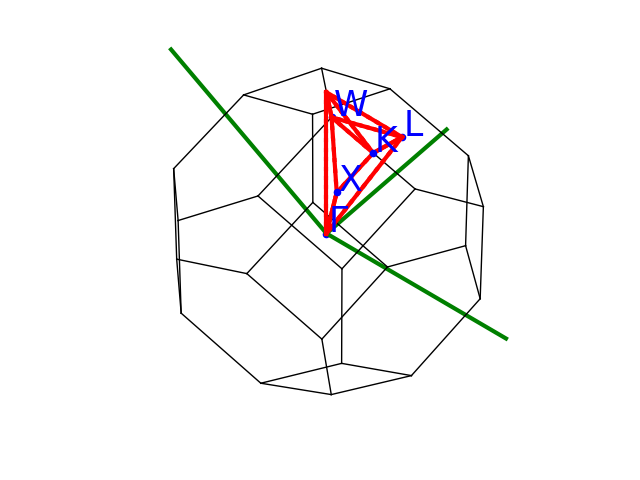

In [12]:
ebands_kpath.kpoints.plot();

<IPython.core.display.Javascript object>


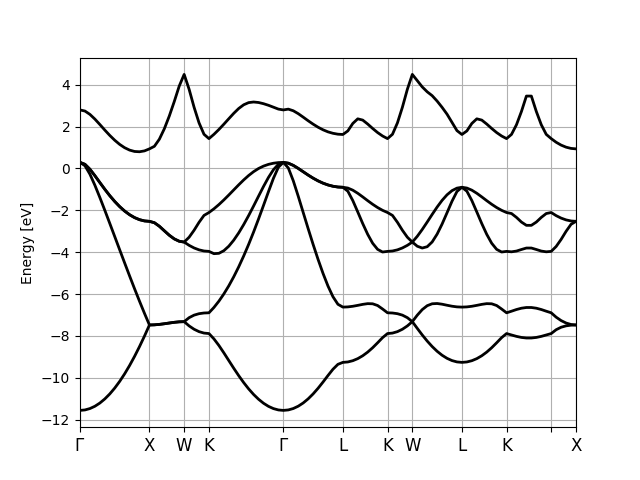

/Users/gmatteo/git_repos/pymatgen/pymatgen/symmetry/bandstructure.py:63: UserWarning: The input structure does not match the expected standard primitive! The path can be incorrect. Use at your own risk.
  warnings.warn("The input structure does not match the expected standard primitive! "


In [13]:
ebands_kpath.plot();

In [14]:
#with abilab.abiopen("flow_base3_ebands/w0/t2/outdata/out_GSR.nc") as gsr:
#    ebands_kmesh = gsr.ebands